In [265]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature
from skimage.morphology import reconstruction
from scipy import stats, ndimage
from scipy.misc import factorial as fac

import photutils

from astropy import units
from astropy import stats
from astropy import visualization
from astropy import coordinates
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

from mmtwfs.zernike import calc_influence_matrix, noll_normalization_vector, zernike_noll

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
NMPERRAD = 6.502e9 / 2.
NMPERASEC = NMPERRAD  / 206265.
PIXSIZE = 0.156  # arcsec
TILTFACTOR = PIXSIZE * NMPERASEC

In [266]:
def cart2pol(arr):
    """
    convert array of [x, y] vectors to [rho, theta]
    """
    x = arr[0]
    y = arr[1]
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.array([rho, theta])

def pol2cart(arr):
    """
    convert array of [rho, theta] vectors to [x, y]
    """
    rho = arr[0]
    theta = arr[1]
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return np.array([x, y])

def mk_pupil_model(size=400):
    """
    Use photutils to make an annular mask to use as a model for what a pupil should look like. 
    Arguments
    ---------
    size: int
        Image size in pixels (size x size)
        
    Returns
    -------
    mask:  2D np.ndarray
        Mask containing annular pupil model
    """
    annulus = np.zeros((size, size))
    # this mask will be 1 inside the annulus, 0 outside, and interpolated in pixels that are partially overlapped
    outer = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 175, use_exact=0, subpixels=5)
    inner = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 40, use_exact=0, subpixels=5)
    mask = annulus + outer - inner
    return mask

def plot_wfsfind(data, sources, ap_radius=5.0):
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = photutils.CircularAperture(positions, r=ap_radius)
    norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
    plt.imshow(data, cmap='gray', origin='lower', norm=norm, interpolation='None')
    apertures.plot(color='red', lw=1.5, alpha=0.5)

def wfsfind(data, fwhm=5.0, threshold=7.0, plot=False, ap_radius=5.0):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    daofind = photutils.DAOStarFinder(fwhm=fwhm, threshold=threshold*std)
    sources = daofind(data - median)
    if plot:
        plot_wfsfind(data, sources, ap_radius=ap_radius)
    return sources

def get_spacing(data):
    """
    Measure the WFS grid spacing which changes with telescope focus.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS data to analyze
        
    Returns
    -------
    xspacing, yspacing: float, float
        Average grid spacing in X and Y axes
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # sum along the axes and use Lomb-Scargle to measure the grid spacing in each direction
    xsum = np.sum(data, axis=0)
    ysum = np.sum(data, axis=1)
    x = np.arange(len(xsum))
    y = np.arange(len(ysum))
    k = np.linspace(5.0, 50., 1000.)  # look for spacings from 5 to 50 pixels (plenty of range)
    f = 1.0 / k  # convert spacing to frequency
    xp = stats.LombScargle(x, xsum).power(f)
    yp = stats.LombScargle(y, ysum).power(f) 
    # the peak of the power spectrum will coincide with the average spacing
    xspacing = k[xp.argmax()]
    yspacing = k[yp.argmax()]
    return xspacing, yspacing

def mk_reference(data, xoffset=0, yoffset=0, plot=False, pup_inner=45., pup_outer=175.):
    """
    Read WFS reference image and generate reference magnifications (i.e. grid spacing) and
    aperture positions.
    
    Arguments
    ---------
    data: FITS filename or 2D ndarray
        WFS reference image
    xoffset, yoffset: float
        Offsets in units of aperture spacing between the center of the reference aperture grid
        and the center of the pupil projected onto the grid.
    plot: bool
        Toggle plotting of the reference image and overlayed apertures
    pup_inner: float
        Reference radius in pixels of the central hole of the pupil
    pup_outer: float
        Reference radius in pixels of the outer extent of the pupil
        
    Returns
    -------
    ref: dict
        Keys - 
            xspacing: float
                Mean grid spacing along X axis (pixels)
            yspacing: float
                Mean grid spacing along Y axis (pixels)
            apertures: astropy.Table
                Reference apertures within pup_inner and pup_outer
            pup_coords: tuple (1D ndarray, 1D ndarray)
                X and Y positions of apertures in pupil coordinates
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    spots = wfsfind(data, fwhm=4.0, threshold=30.0, plot=plot)
    xcen = spots['xcentroid'].mean()
    ycen = spots['ycentroid'].mean()
    spacing = get_spacing(data)
    # just using the mean will be offset from the true center due to missing spots at edges.
    # find the spot closest to the mean and make it the center position of the pattern.
    dist = ((spots['xcentroid'] - xcen)**2 + (spots['ycentroid'] - ycen)**2)
    closest = np.argmin(dist)
    xoff = spots['xcentroid'][closest] - xcen
    yoff = spots['ycentroid'][closest] - ycen
    xcen += xoff
    ycen += yoff
    spots['xcentroid'] -= xcen + xoffset*spacing[0]
    spots['ycentroid'] -= ycen + yoffset*spacing[1]
    spots['dist'] = np.sqrt(spots['xcentroid']**2 + spots['ycentroid']**2)
    ref = {}
    ref['xspacing'] = spacing[0]
    ref['yspacing'] = spacing[1]
    spacing = (spacing[0] + spacing[1])/2.
    # we set the limit to half an aperture spacing in from the outer edge to make sure all of the points
    # lie within the zernike radius
    ref['apertures'] = spots[(spots['dist'] > pup_inner) & (spots['dist'] < pup_outer-0.5*spacing)]
    ref['pup_coords'] = (ref['apertures']['xcentroid']/pup_outer, ref['apertures']['ycentroid']/pup_outer)
    ref['pup_inner'] = pup_inner
    ref['pup_outer'] = pup_outer
    return ref

def center_pupil(data, threshold=0.95, pup_size=400, plot=False, smooth=False):
    """
    Find the center of the pupil in a WFS image using skimage.feature.match_template(). This generates
    a correlation image and we centroid the peak of the correlation to determine the center.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS image to analyze, either FITS file or ndarray image data
    plot: bool
        Toggle plotting of the correlation image
        
    Returns
    -------
    cen: tuple (float, float)
        X and Y pixel coordinates of the pupil center
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
    # the location of the peak of the correlation will be the center of the WFS pattern.
    mask = mk_pupil_model(size=pup_size)
    seed = np.copy(data)
    seed[1:-1, 1:-1] = data.min()
    dilated = reconstruction(seed, data, method='dilation')
    subt = data - dilated
    match = feature.match_template(subt, mask, pad_input=True)
    match[match < threshold * match.max()] = 0
    cen = photutils.centroids.centroid_com(match)
    if plot:
        plt.imshow(match, interpolation=None, origin='lower')
    return cen

def get_apertures(data, ref, xcen, ycen, xspacing, yspacing):
    """
    Use the X/Y center positions and grid spacings to place the reference apertures onto the WFS
    frame.  Perform center-of-mass centroiding within each aperture.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS image to analyze, either FITS file or ndarray image data
    ref: astropy.Table
        Table of reference aperture positions
    xcen, ycen: float, float
        X and Y positions of the pupil center
    xspacing, yspacing: float, float
        Aperture grid spacing along X and Y axes
        
    Returns
    -------
    apers: photutils.CircularAperture
        WFS apertures scaled and placed onto image
    masks: list of photutils.ApertureMask objects
        Masks used for aperture centroiding
    offsets: list of tuples
        X/Y offsets of spot centroids from aperture centers
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
        
    # we use circular apertures here because they generate square masks of the appropriate size.
    # rectangular apertures produced masks that were sqrt(2) too large.
    # see https://github.com/astropy/photutils/issues/499 for details.  
    apers = photutils.CircularAperture(
        ((xspacing/ref['xspacing'])*ref['apertures']['xcentroid']+xcen,
        (yspacing/ref['yspacing'])*ref['apertures']['ycentroid']+ycen),
        r=(xspacing + yspacing)/4.
    )
    masks = apers.to_mask(method='subpixel')
    offsets = []
    for m in masks:
        subim = m.cutout(data)
        # center-of-mass centroiding is the fastest, most reliable method, especially for faint or elongated spots
        spotx, spoty = photutils.centroid_com(subim)
        offsets.append((spotx-m.shape[1]/2, spoty-m.shape[0]/2))
    offsets = np.array(offsets)
    return apers, masks, offsets
    
def get_slopes(file, ref, plot=False):
    """
    Analyze a WFS image and produce pixel offsets between reference and observed spot positions.
    
    Arguments
    ---------
    file: str
        FITS file containing WFS observation
    ref: astropy.Table
        Table of reference apertures
    plot: bool
        Toggle plotting of image with aperture overlays
        
    Returns
    -------
    slopes: list of tuples
        X/Y pixel offsets between measured and reference aperture positions.
    final_aps: astropy.Table
        Centroided observed apertures
    xspacing, yspacing: float, float
        Observed X and Y grid spacing
    xcen, ycen: float, float
        Center of pupil image
    data: 2D ndarray
        WFS image contained in 'file'
    """
    data = fits.open(file)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    data -= median
    xcen, ycen = center_pupil(data, plot=False)
    xspacing, yspacing = get_spacing(data)
    # get initial apertures, find mean offset, and fine tune the centration
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xspacing, yspacing)
    xcen += pos[0].mean()
    ycen += pos[1].mean()
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xspacing, yspacing)
    meas_pos = apers.positions + pos
    final_aps = photutils.CircularAperture(
            meas_pos,
            r=4.
    )
    ref_aps = photutils.CircularAperture(
        (ref['apertures']['xcentroid']+xcen, ref['apertures']['ycentroid']+ycen),
        r=(xspacing + yspacing) / 4.    
    )
    spacing = (xspacing + yspacing) / 2.
    ref_spacing = (ref['xspacing'] + ref['yspacing']) / 2.
    pup_size = ref['pup_outer']
    slopes = final_aps.positions - ref_aps.positions
    pup_coords = (ref_aps.positions - [xcen, ycen]) / [pup_size, pup_size]
    
    if plot:
        norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
        plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='None')
        apers.plot(color='red')
        plt.scatter(xcen, ycen)
        final_aps.plot(color='yellow')
    return slopes.transpose(), pup_coords.transpose(), final_aps, (xspacing, yspacing), (xcen, ycen), data

<IPython.core.display.Javascript object>


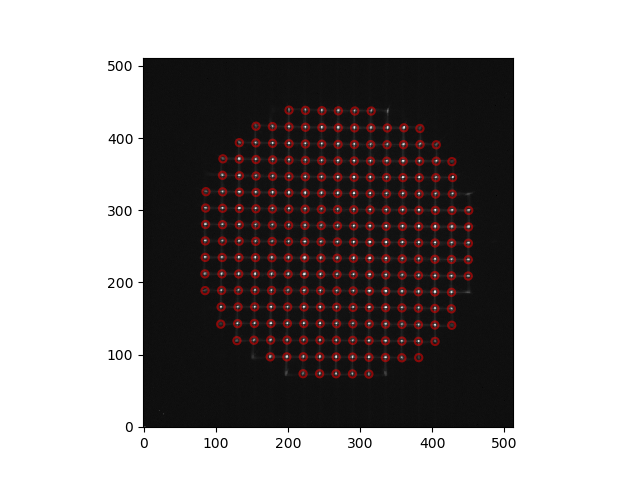

In [260]:
rs = mk_reference("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera2_ref.fits", yoffset=-0.5, pup_inner=50., pup_outer=180., plot=True)
plt.show()

<IPython.core.display.Javascript object>


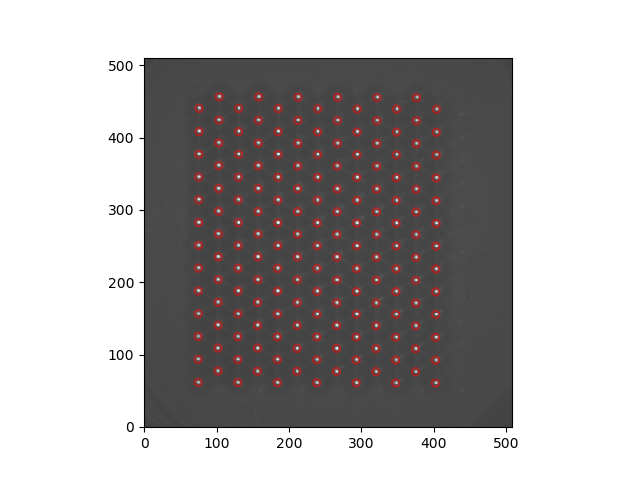

In [261]:
rs = mk_reference("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/f9_ref.fits", yoffset=1.5, xoffset=0.85, pup_inner=45., pup_outer=220., plot=True)
plt.show()

<IPython.core.display.Javascript object>


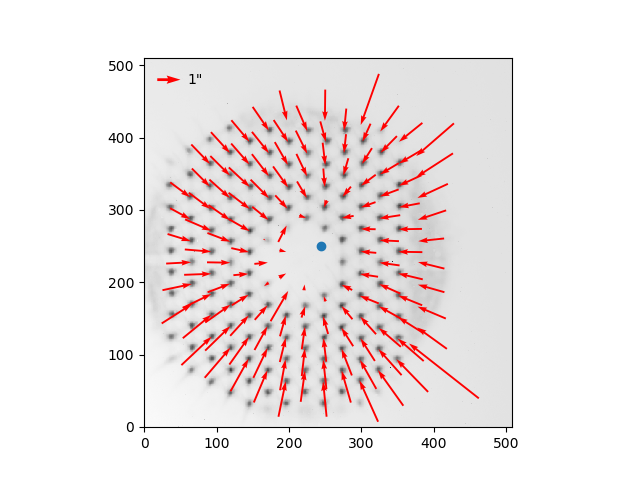

(244.72986948662626, 250.22947869193041) (26.036036036036034, 15.045045045045045)


In [336]:
slopes, coords, aps, spacing, cen, im = get_slopes("/Users/tim/MMT/wfsdat/20170108/manual_wfs_0001.fits", rs, plot=False)
refap = photutils.RectangularAperture(
    (rs['apertures']['xcentroid']+cen[0], rs['apertures']['ycentroid']+cen[1]), 
    w=22,
    h=22, 
    theta=0.0
)
x = aps.positions.transpose()[0]
y = aps.positions.transpose()[1]
u = slopes[0]
v = slopes[1]
norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
plt.imshow(im, cmap='Greys', origin='lower', norm=norm, interpolation='None')
plt.quiver(x, y, u, v, scale_units='xy', scale=0.2, pivot='tip', color='red')
xl = [50.0]
yl = [480.0]
ul = [1.0/PIXSIZE]
vl = [0.0]
plt.quiver(xl, yl, ul, vl, scale_units='xy', scale=0.2, pivot='tip', color='red')
plt.scatter([cen[0]], [cen[1]])
plt.text(60, 480, "1\"", verticalalignment='center')
plt.show()
print(cen, spacing)
#plt.savefig("blah.png")

<IPython.core.display.Javascript object>


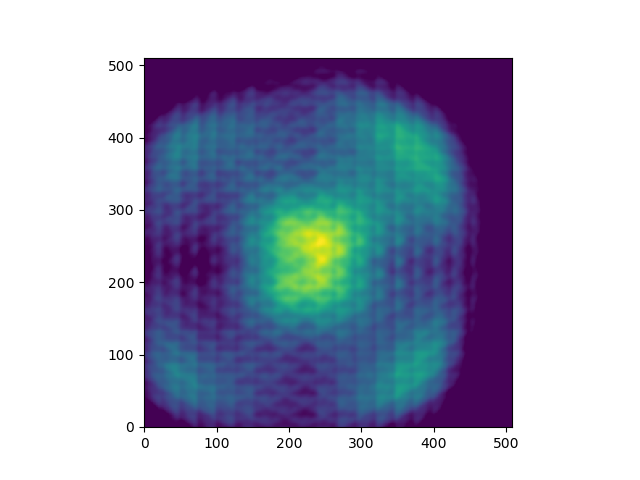

In [337]:
center_pupil(im, plot=True, threshold=0.0)
plt.show()

<IPython.core.display.Javascript object>


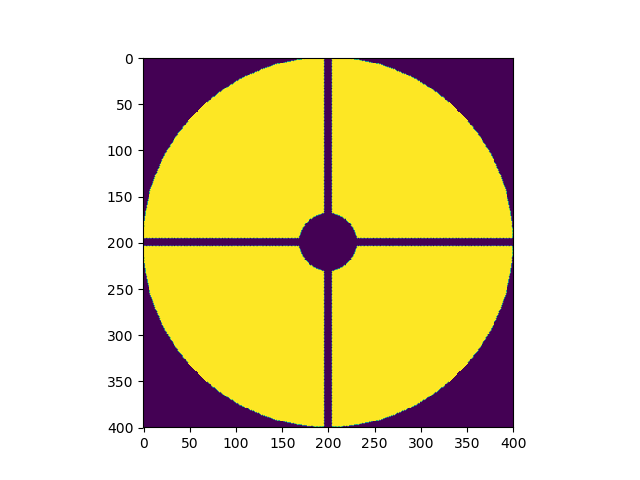

In [338]:
from mmtwfs.telescope import MMT
from scipy.misc import imrotate
t = MMT(secondary='f9')
pup = t.pupil_mask()
pup = imrotate(pup, -225)
plt.imshow(pup)
plt.show()

<IPython.core.display.Javascript object>


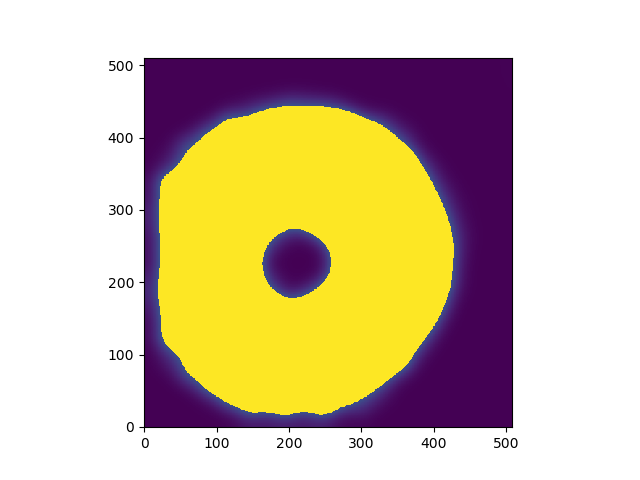

In [339]:
#c = center_pupil(im, threshold=0.1, pup_size=420, plot=True)
data = ndimage.gaussian_filter(im, 1)
seed = np.copy(data)
seed[1:-1, 1:-1] = data.min()
dilated = reconstruction(seed, data, method='dilation')
subt = data - dilated

subt = ndimage.gaussian_filter(subt, 15)
subt /= subt.max()
subt[subt > 0.25] = 1
plt.imshow(subt, origin='lower')
plt.show()

[ 212.79947088  231.09421852]


<IPython.core.display.Javascript object>


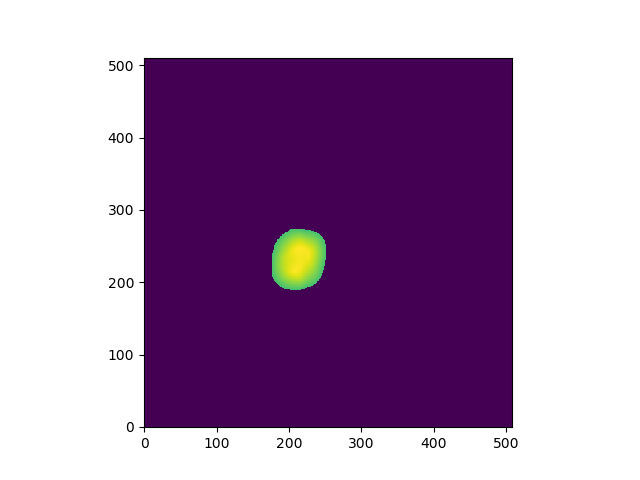

In [340]:
threshold=0.7
match = feature.match_template(subt, pup, pad_input=True)
match[match < threshold * match.max()] = 0
cen = photutils.centroids.centroid_com(match)
print(cen)
plt.imshow(match, origin='lower')
plt.show()

In [6]:
subaps = []
ap = rs['apertures']
bounds = np.array([ap['xcentroid'].data+180-11, ap['xcentroid'].data+180+11, ap['ycentroid'].data+180-11, ap['ycentroid'].data+180+11])

infmat = calc_influence_matrix(bounds.transpose(), nbasis=20, cntr=np.array([179.5, 179.5]), rad=180.0, pixsize=PIXSIZE)

infmat[1].shape, slopes[0].shape

/Users/tim/conda/envs/astroconda/lib/python3.5/site-packages/numpy/core/numeric.py:2000: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = empty((N,)+dimensions, dtype=dtype)
/Users/tim/conda/envs/astroconda/lib/python3.5/site-packages/numpy/core/numeric.py:2003: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp.shape = (1,)*i + (dim,)+(1,)*(N-i-1)
/Users/tim/conda/envs/astroconda/lib/python3.5/site-packages/numpy/core/numeric.py:2005: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val = zeros(newdim, dtype)
/Users/tim/MMT/mmtwfs/mmtwfs/zernike.py:434: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ) for subap in subaps


((20, 308), (154,))

In [7]:
slope_vec = -TILTFACTOR*slopes.transpose().ravel() / 206265.

zfit = np.dot(slope_vec, infmat[0])
coeffs = {}
norms = noll_normalization_vector()
#zfit[2] -= 1912.0
for i, z in enumerate(zfit):
    key = "Z%d" % (i+2)
    norm = norms[i+1]
    noll_coeff = z * 1.0e-3 / norm
    coeffs[key] = float("%.3f" % noll_coeff)
    print("%9.3f %d" % (z, i+2))
coeffs['Z2'] = 0.0
coeffs['Z3'] = 0.0

 3822.081 2
  -97.154 3
 2362.786 4
  -20.243 5
  465.754 6
  116.813 7
 -415.679 8
 -113.336 9
 -309.387 10
  236.332 11
  180.883 12
   16.792 13
  226.904 14
 -149.779 15
 -100.001 16
  -62.178 17
 -124.605 18
   -1.205 19
 -103.087 20
   46.092 21


0.0807876898275 1273.31723574


<IPython.core.display.Javascript object>


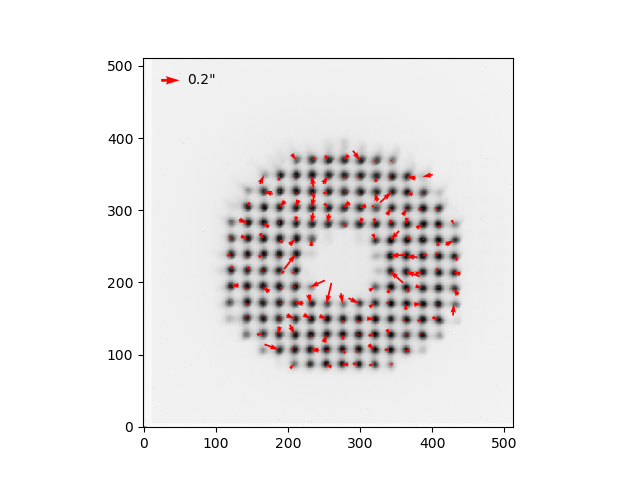

In [8]:
pred = np.dot(zfit, infmat[1])
pred = -(206265./TILTFACTOR) * pred.reshape(slopes.shape[1], 2).transpose()
np.sqrt((pred[0] - slopes[0])**2 + (pred[1] - slopes[1])**2).mean()
diff = slopes - pred

rms = PIXSIZE*np.sqrt((diff[0]**2 + diff[1]**2).mean())
print(rms, rms*NMPERASEC)
gnorm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
plt.imshow(im, cmap='Greys', origin='lower', norm=gnorm, interpolation='None')
plt.quiver(x, y, diff[0], diff[1], scale_units='xy', scale=0.05, pivot='tip', color='red')
xl = [50.0]
yl = [480.0]
ul = [0.2/PIXSIZE]
vl = [0.0]
plt.quiver(xl, yl, ul, vl, scale_units='xy', scale=0.05, pivot='tip', color='red')
plt.text(60, 480, "0.2\"", verticalalignment='center')
plt.show()

In [9]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0373.fits"
center = ascii.read("/Users/tim/MMT/shwfs/mmirs2_reference.center")
ref = ascii.read("/Users/tim/MMT/shwfs/mmirs2_sysfile.cntr")
ref1_fits = "/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera1_ref.fits"
ref2_fits = "/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera2_ref.fits"
# test images from 20170110: 1, 7, 44, 61, 126, 131-138, 161-168, 183-189, 194-198, 298-299, 327, 369-372
test_fits = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0335.fits"

im = fits.open(file)[0].data
ref1_im = fits.open(ref1_fits)[0].data
ref2_im = fits.open(ref2_fits)[0].data
test = fits.open(test_fits)[0].data

<IPython.core.display.Javascript object>


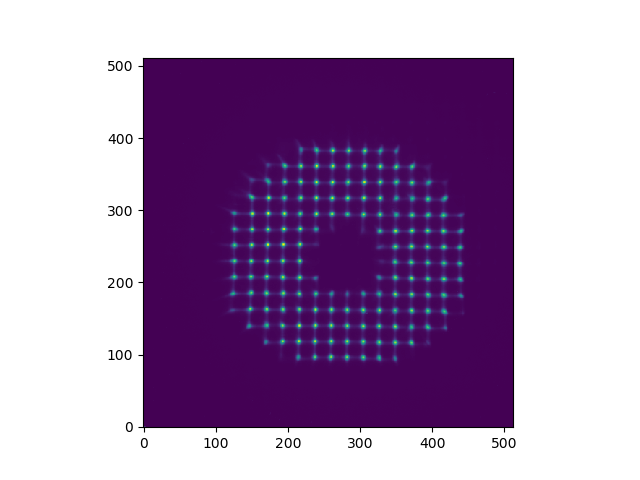

In [10]:
plt.imshow(test, interpolation='nearest', origin='lower')
#plt.scatter(ref['col1'], ref['col2'], color='purple')
#plt.scatter(center['col1'], center['col2'], marker='x', color='white')
#plt.scatter(271, 229, marker='x', color='white')
plt.show()

In [11]:
# use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
# the location of the peak of the correlation will be the center of the WFS pattern.
result = feature.match_template(test, mask, pad_input=True)
plt.imshow(result, interpolation='nearest', origin='lower')
plt.show()

NameError: name 'mask' is not defined

In [12]:
# the correlation image is somewhat complicated, but the peak is distinct as long as there are detectable WFS spots.
# clip the image at 90% of the peak and then do a center-of-mass centroid on it. 
plt.imshow(test, interpolation='nearest', origin='lower')
result[result < 0.9*result.max()] = 0
cen = photutils.centroids.centroid_com(result)
plt.scatter(cen[0], cen[1], marker='x', color='white')
plt.show()

NameError: name 'result' is not defined

In [13]:
# ndimage and photutils should give the same answer for CoM centroids...
ndimage.center_of_mass(result)

NameError: name 'result' is not defined

In [14]:
ref_file = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref_data = fits.open(ref_file)[0].data
mean, median, std = stats.sigma_clipped_stats(ref_data, sigma=3.0, iters=5)

daofind = photutils.DAOStarFinder(fwhm=4, threshold=30.0*std)
#starfind = photutils.IRAFStarFinder(fwhm=2.0, threshold=5.0*std)

dao_sources = daofind(ref_data - median)
#iraf_sources = starfind(ref_data - median)

plot_wfsfind(ref_data, dao_sources, ap_radius=0.5)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits'

<IPython.core.display.Javascript object>


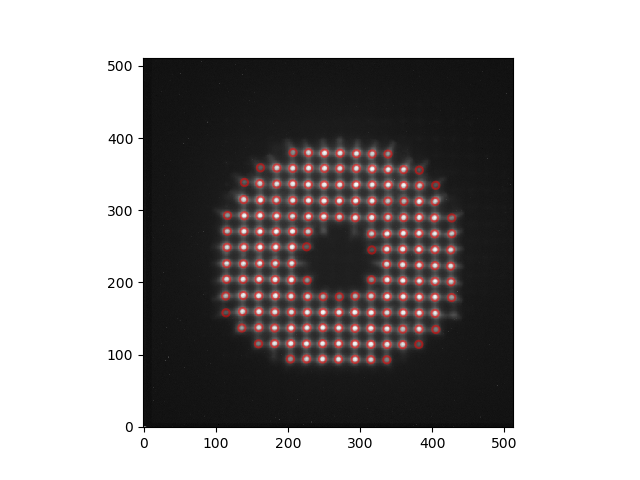

In [15]:
s = wfsfind("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0232.fits", fwhm=7.0, plot=True)
s.sort(['xcentroid'])
plt.show()

<IPython.core.display.Javascript object>


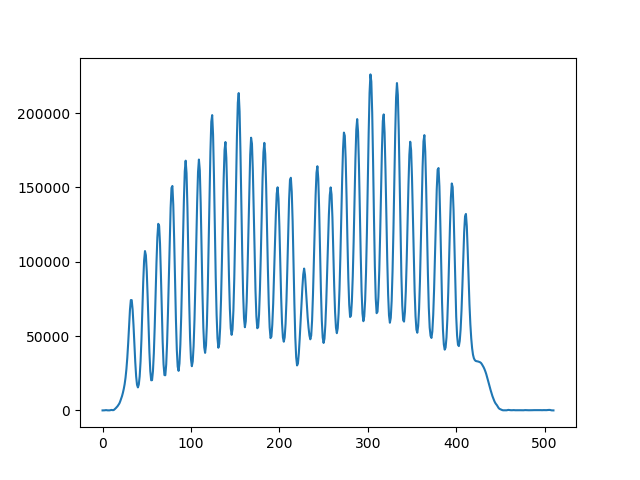

(26.081081081081081, 15.045045045045045)


In [277]:
#data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
#data = fits.open("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera1_ref.fits")[0].data
data = subt
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(y)
plt.show()
print(get_spacing(data))

<IPython.core.display.Javascript object>


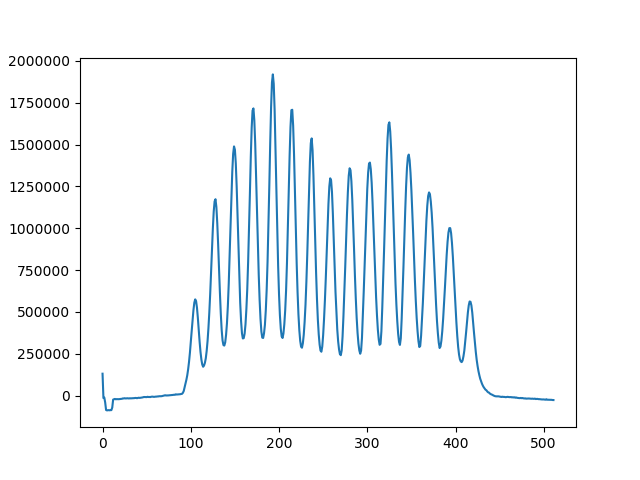

(22.117117117117115, 22.522522522522522)


In [18]:
data = fits.open("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0138.fits")[0].data
mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
data -= median
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_spacing(data))

<IPython.core.display.Javascript object>


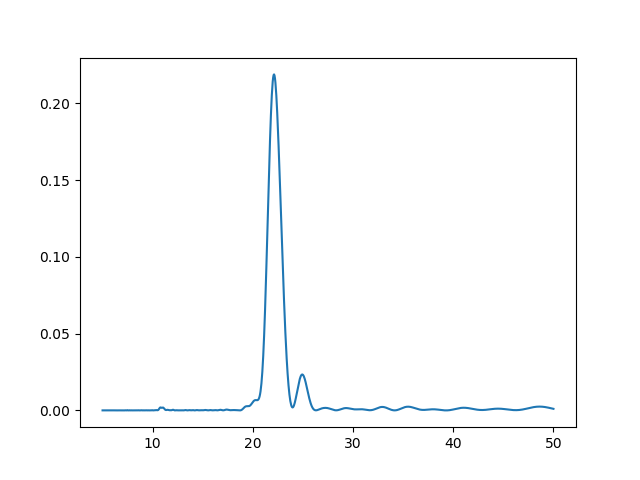

In [19]:
d = np.sum(data, axis=0)
t = np.arange(len(d))
k = np.linspace(5.0, 50., 1000.)
p = stats.LombScargle(t, d).power(1.0/k)
plt.plot(k, p)
plt.show()

In [20]:
ACT = 104
NODE = 3222
BRAD = 3228.5

In [21]:
# for each node, the influence from each actuator
surf2act = np.fromfile("/Users/tim/MMT/mmtwfs/mmtwfs/data/Surf2ActTEL_32.bin", dtype=np.float32).reshape(ACT, NODE).transpose()
nodes = ascii.read("/Users/tim/MMT/mmtwfs/mmtwfs/data/bcv_node_coordinates.dat", names=["bcv_id", "bcv_x", "bcv_y", "bcv_z"])
for ax in ["bcv_x", "bcv_y"]:
    nodes[ax] /= BRAD
nodes['bcv_rho'] = np.sqrt(nodes['bcv_x']**2 + nodes['bcv_y']**2)
nodes['bcv_phi'] = np.arctan2(nodes['bcv_y'], nodes['bcv_x'])

In [22]:
len(zfit)

20

In [23]:
def zern_phase(zvec, rho, phi, modestart=2):
    phase = 0.0
    for i, z in enumerate(zvec):
        l = i + modestart
        ph = z * zernike_noll(l, rho, phi)
        phase += ph
    return phase

<IPython.core.display.Javascript object>


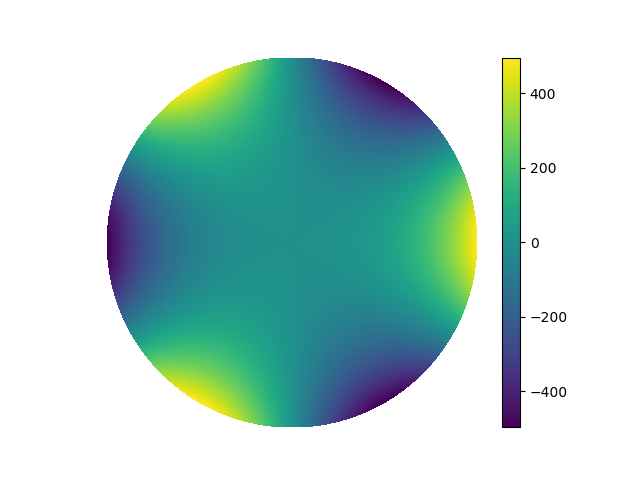

In [24]:
ztest = np.zeros(20)
ztest[8] = 500.0
ztest

rho = np.linspace(0.0, 1.0, 400)
phi = np.linspace(0, 2*np.pi, 400)
[p, r] = np.meshgrid(phi, rho)
x = r * np.cos(p)
y = r * np.sin(p)
ph = zern_phase(ztest, r, p, modestart=2)
fig = plt.pcolormesh(x, y, ph)
fig.axes.set_axis_off()
fig.axes.set_aspect(1.0)
plt.colorbar()
plt.show()


In [25]:
ztest = np.zeros(20)
ztest[7] = 500.0
print(ztest)
mir_ph = 0.5*zern_phase(ztest, nodes['bcv_rho'].data, nodes['bcv_phi'].data)

np.dot(mir_ph, surf2act)

[   0.    0.    0.    0.    0.    0.    0.  500.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


array([ 20.77128215,  13.16363539,   5.25117218,   6.38250404,
         5.74255561, -10.33929197, -13.55381861,  -7.57732274,
        -3.61077591, -14.65459426,  -2.18659916,   2.51270369,
         0.641273  , -22.46370441,   4.92997527,   6.18986919,
        15.24642357,   4.72303825, -27.07854981, -13.23059305,
         3.18770156,  13.49260998,  -1.84324519, -18.1190972 ,
         0.0768706 ,  -0.15589992,   0.0993605 ,   0.0680983 ,
        13.57977499,  -3.46965527, -13.63412433,   1.98520483,
        18.04274342,  -4.88222388,  -6.38280774, -15.49483715,
        -4.65010748,  27.1799421 ,   2.04034763,  -2.64762446,
        -0.655079  ,  22.58373948,  13.48553678,   7.54920886,
         3.62134397,  14.72548295,  -6.34561374,  -5.6995156 ,
        10.41241056, -20.70071916, -13.09646712,  -5.18548321,
        20.77128215,  13.16363539,   5.25117218,   6.38250404,
         5.74255561, -10.33929197, -13.55381861,  -7.57732274,
        -3.61077591, -14.65459426,  -2.18659916,   2.51

In [26]:
ztest = np.zeros(20)
ztest[3] = 1000.0
print(ztest)
mir_ph = -0.5*zern_phase(ztest, nodes['bcv_rho'].data, nodes['bcv_phi'].data)

np.dot(mir_ph, surf2act)

[    0.     0.     0.  1000.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]


array([  2.40413614,   5.32637921,   6.49496311,   1.15894132,
         1.95779584,  11.96833499,  -0.94238513,  -5.12141917,
        -2.51449916,  10.3472205 ,  -3.33027533, -10.83978095,
        -5.67366496,  14.39862925,   1.67152225,  -0.28076418,
       -11.49272383,  -5.15514973,  12.72111127,   7.36907901,
         0.2341428 ,  -8.16214049,  -1.61794716,   5.28460998,
        -0.42861262,   0.29463059,   0.4277538 ,  -0.07875992,
        -8.03285617,  -0.21167434,   9.02362443,   2.03111615,
        -5.99239314,  -1.72137064,   0.34428834,  12.06048979,
         5.49822034, -13.29331489,   3.58853897,  11.36381793,
         5.97192372, -14.81959923,   1.04269628,   5.45587381,
         2.68812725, -10.60517941,  -1.12320584,  -1.97067151,
       -12.32834104,  -2.43509825,  -5.48813131,  -6.71858176,
        -2.40413614,  -5.32637921,  -6.49496311,  -1.15894132,
        -1.95779584, -11.96833499,   0.94238513,   5.12141917,
         2.51449916, -10.3472205 ,   3.33027533,  10.83

In [76]:
from mmtwfs.telescope import MMT
from mmtwfs.zernike import ZernikeVector
from astropy.table import Table
import sys

In [68]:
t = MMT()
zv = ZernikeVector(Z05=-1000.)

f = t.bending_forces(zv=zv, zfile=False)

In [70]:
act_i = t.actcoor['act_id']

In [83]:
t = Table([act_i, f], names=['actuator', 'force'])

In [89]:
t.write("blah", format="ascii.no_header", delimiter="\t", formats={'force': ".1f"})

In [90]:
import filecmp

In [91]:
filecmp.cmp("blah", "/Users/tim/MMT/mirfor/AST45_p1000.frc")

True